# XGBoost - Lab

## Introduction

In this lab, we'll install the popular [XGBoost Library](http://xgboost.readthedocs.io/en/latest/index.html) and explore how to use this popular boosting model to classify different types of wine using the [Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the UCI Machine Learning Dataset Repository.  In this lesson, we'll install XGBoost on our machines, and then we'll use it make some classifications on the **_Wine Quality Dataset_**!

## Objectives

You will be able to:

* Understand the general difference between XGBoost and other ensemble algorithms such as AdaBoost
* Install and use XGboost

## Installing XGBoost

The XGBoost model is not currently included in scikit-learn, so we'll have to install it on our own.  To install XGBoost, you'll need to use conda. 

To install XGBoost, follow these steps:

1. Open up a new terminal window.
2. Activate your conda environment
3. Run `conda install py-xgboost`. You must use conda to install this package--currently, it cannot be installed using `pip`. 
4. Once installation has completed, run the cell below to verify that everything worked. 

In [1]:
import xgboost as xgb

Run the cell below to import everything we'll need for this lab. 

In [12]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns

The dataset we'll be using for this lab is currently stored in the file `winequality-red.csv`.  

In the cell below, use pandas to import the dataset into a dataframe, and inspect the head of the dataframe to ensure everything loaded correctly. 

In [4]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


For this lab, our target variable will be `quality` .  That makes this a multiclass classification problem. Given the data in the columns from `fixed_acidity` through `alcohol`, we'll predict the `quality` of the wine.  

This means that we need to store our target variable separately from the dataset, and then split the data and labels into training and testing sets that we can use for cross-validation. 

In the cell below:

* Store the `quality` column in the `labels` variable and then remove the column from our dataset.  
* Create a `StandardScaler` object and scale the data using the `fit_transform()` method.
* Split the data into training and testing sets using the appropriate method from sklearn.  

In [5]:
labels = df['quality']
labels_removed_df = df.drop('quality', axis=1, inplace=False)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(labels_removed_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)

Now that we have prepared our data for modeling, we can use XGBoost to build a model that can accurately classify wine quality based on the features of the wine!

The API for xgboost is purposefully written to mirror the same structure as other models in scikit-learn.  

In [16]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 80.9%
Validation accuracy: 63.25%


In [10]:
def create_cm(y_test, y_pred):
    cf_test = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix Test: ")
    akws = {"ha": 'center',"va": 'top'}
    sns.heatmap(cf_test/(np.sum(cf_test)),annot=True, fmt='0.2%',cmap='Blues', annot_kws=akws, cbar=False)

    akws = {"ha": 'center',"va": 'bottom'}
    sns.heatmap(cf_test,annot=True, fmt='0',cmap='Blues', annot_kws=akws)
    plt.show()

Confusion Matrix Test: 


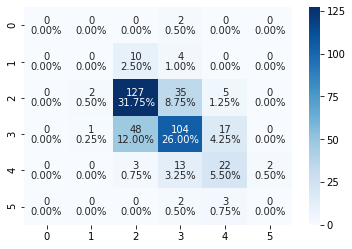

In [13]:
create_cm(y_test, val_preds)

## Tuning XGBoost

Our model had somewhat lackluster performance on the testing set compared to the training set, suggesting the model is beginning to overfit the training data.  Let's tune the model to increase the model performance and prevent overfitting. 

For a full list of model parameters, see the [XGBoost Documentation](http://xgboost.readthedocs.io/en/latest/parameter.html).

Many of the parameters we'll be tuning are parameters we've already encountered when working with Decision Trees, Random Forests, and Gradient Boosted Trees.  

Examine the tunable parameters for XGboost, and then fill in appropriate values for the `param_grid` dictionary in the cell below. Put values you want to test out  for each parameter inside the corresponding arrays in `param_grid`.  

**_NOTE:_** Remember, `GridSearchCV` finds the optimal combination of parameters through an exhaustive combinatoric search.  If you search through too many parameters, the model will take forever to run! For the sake of time, we recommend trying no more than 3 values per parameter for the following steps.  

In [21]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250],
}

Now that we have constructed our `params` dictionary, create a `GridSearchCV` object in the cell below and use it to iterate tune our XGBoost model.  

Now, in the cell below:

* Create a `GridSearchCV` object. Pass in the following parameters:
    * `clf`, our classifier
    * `param_grid`, the dictionary of parameters we're going to grid search through
    * `scoring='accuracy'`
    * `cv=None`
    * `n_jobs=1`
* Fit our `grid_clf` object and pass in `X_train` and `y_train`
* Store the best parameter combination found by the grid search in `best_parameters`. You can find these inside the Grid Search object's `.best_params_` attribute.
* Use `grid_clf` to create predictions for the training and testing sets, and store them in separate variables. 
* Compute the accuracy score for the training and testing predictions. 

In [22]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(scaled_df, labels)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 30
subsample: 0.7

Training Accuracy: 75.31%
Validation accuracy: 78.75%


That's a big improvement! You should see that your accuracy has increased by 10-15%, as well as no more signs of the model overfitting.  

## Summary

Great! We've now successfully made use of one of the most powerful Boosting models in data science for modeling.  We've also learned how to tune the model for better performance using the Grid Search methodology we learned previously.  XGBoost is a powerful modeling tool to have in your arsenal.  Don't be afraid to experiment with it when modeling.